In [1]:
!pip install -q cupy-cuda12x

In [2]:
import csv

file_path = "/content/Topic 2 Information on the beam position and beam width of multiple beams.csv"

with open(file_path, "r") as f:
    reader = csv.reader(f)
    # Read the header row
    header = next(reader)
    print("CSV Headers:")
    print(header)

CSV Headers:
['theta(deg)', 'phi(deg)', 'Beam Width in azimuth(deg)', 'Beam Width in elevation(deg)']


[INFO] Backend: cupy
[Row 0] Task A: θ=90.00°, φ=90.00° | HPBW_el≈5.94°, HPBW_az≈5.94°
[Row 1] Task A: θ=92.54°, φ=86.33° | HPBW_el≈6.22°, HPBW_az≈4.86°
[Row 2] Task A: θ=87.46°, φ=93.67° | HPBW_el≈6.25°, HPBW_az≈4.86°
[Row 3] Task A: θ=92.80°, φ=93.64° | HPBW_el≈6.22°, HPBW_az≈4.86°
[Row 4] Task A: θ=87.33°, φ=86.19° | HPBW_el≈6.14°, HPBW_az≈5.47°
[Row 5] Task A: θ=84.78°, φ=89.85° | HPBW_el≈6.14°, HPBW_az≈5.49°
[Row 6] Task A: θ=95.33°, φ=89.96° | HPBW_el≈6.20°, HPBW_az≈4.85°
[Row 7] Task A: θ=90.26°, φ=97.28° | HPBW_el≈6.21°, HPBW_az≈4.82°
[Row 8] Task A: θ=89.88°, φ=82.56° | HPBW_el≈6.11°, HPBW_az≈5.38°
[Row 9] Task A: θ=82.28°, φ=93.51° | HPBW_el≈6.13°, HPBW_az≈5.46°
[Row 10] Task A: θ=97.81°, φ=86.29° | HPBW_el≈6.13°, HPBW_az≈4.82°
[Row 11] Task A: θ=82.88°, φ=85.01° | HPBW_el≈5.71°, HPBW_az≈5.98°
[Row 12] Task A: θ=98.06°, φ=93.59° | HPBW_el≈6.09°, HPBW_az≈4.82°
[Row 13] Task A: θ=95.03°, φ=82.70° | HPBW_el≈6.15°, HPBW_az≈4.79°
[Row 14] Task A: θ=84.97°, φ=97.30° | HPBW_el≈6.21°

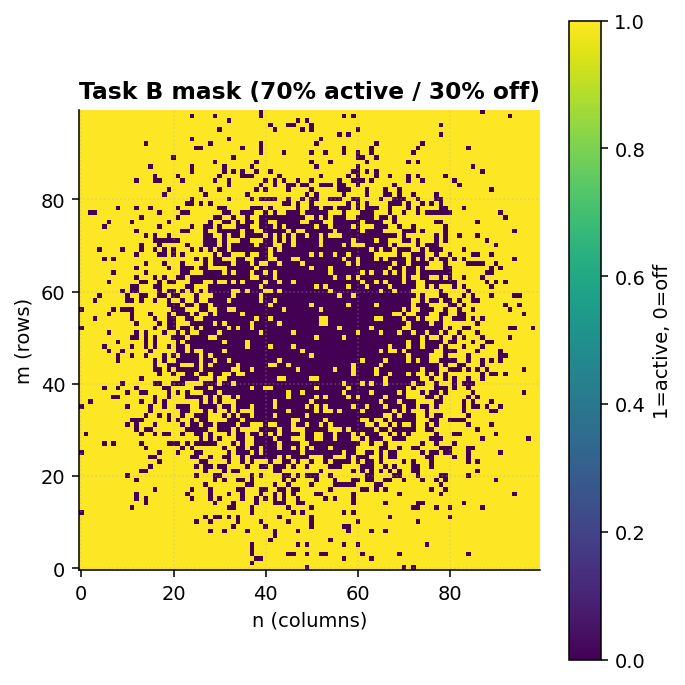

/tmp/ipython-input-3156678435.py:599: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


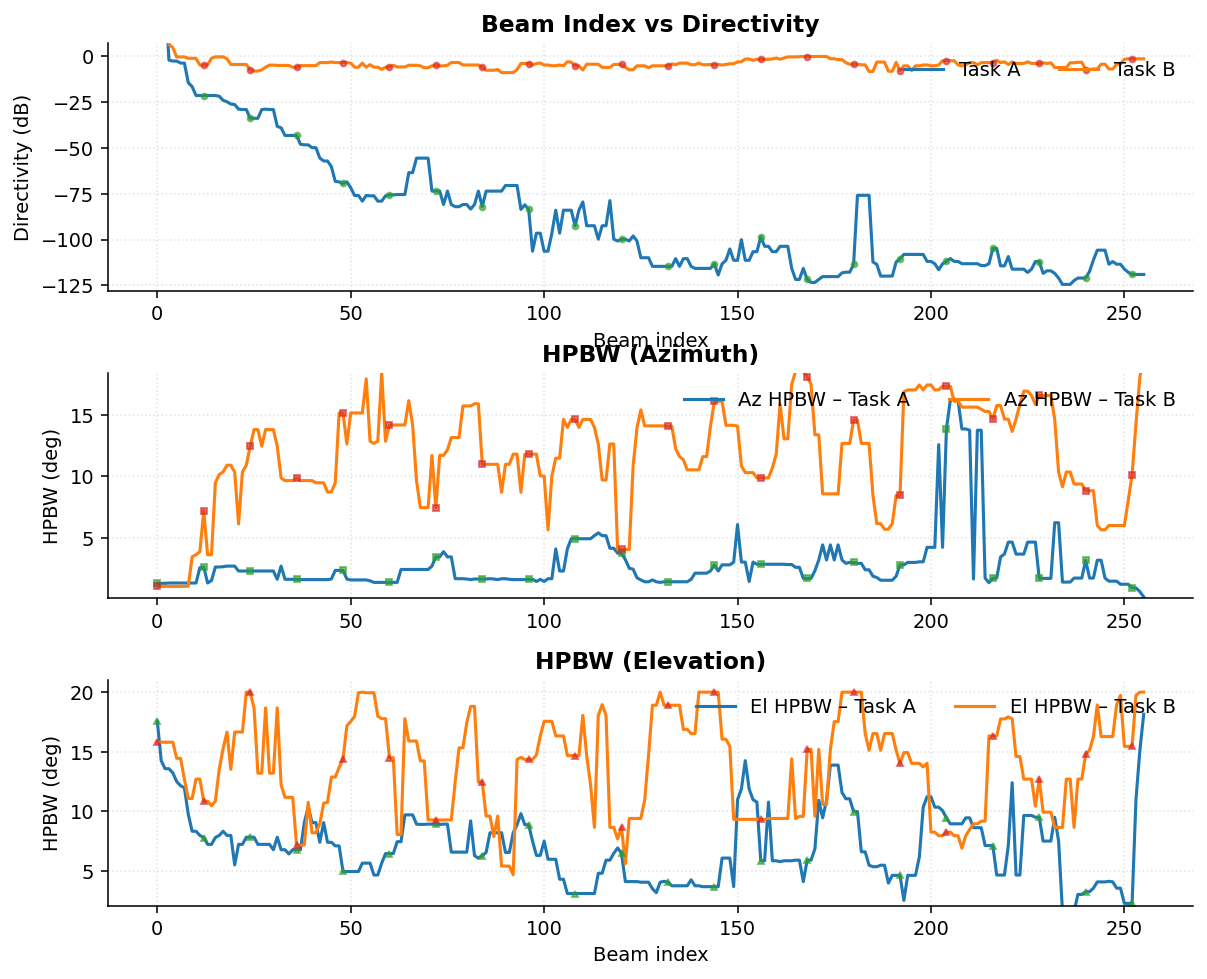

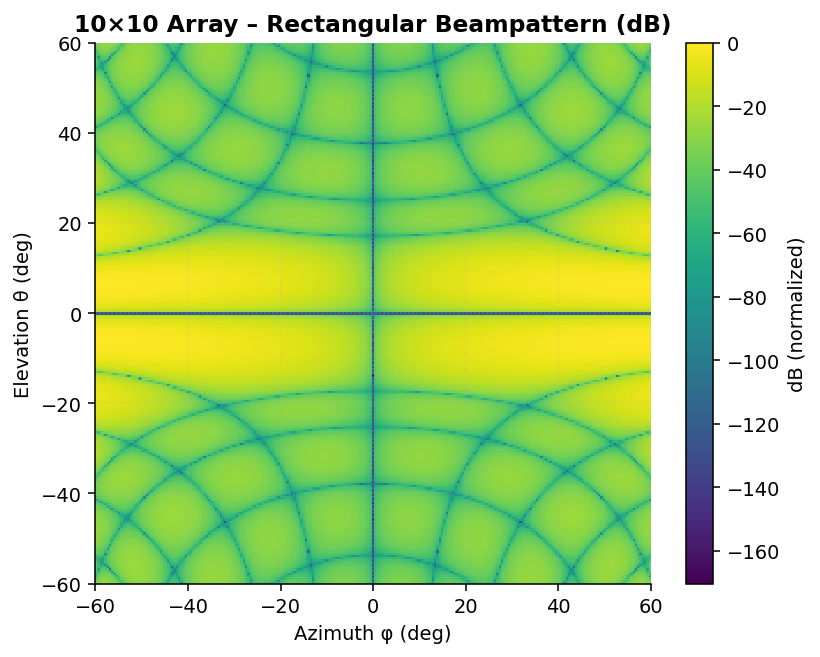

In [4]:
"""
LEO Beamforming – Task A & Task B (CuPy-or-NumPy)
-------------------------------------------------
Reference Python implementation for the Huawei Tech Arena SUB-TOPIC 2 tasks.

This version adds:
  • 10×10 demo rectangular beampattern plot
  • Beam index vs Directivity (gain) curves (Task A & B)
  • Beam index vs HPBW (az & el) curves (Task A & B)
  • 70% active / 30% off mask visualization
"""

from __future__ import annotations
import csv
from dataclasses import dataclass
import typing as t
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager

# Global, subtle style
plt.rcParams.update({
    "figure.dpi": 140,
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.alpha": 0.35,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "semibold",
    "legend.frameon": False,
})

def _to_cpu1(x):
    import numpy as _np
    return _np.asarray(to_cpu(x), dtype=float)

def _running_median(y, k=9):
    k = max(1, int(k) | 1)  # force odd
    y = _to_cpu1(y)
    pad = k//2
    import numpy as _np
    ypad = _np.pad(y, (pad, pad), mode="edge")
    out = _np.empty_like(y)
    for i in range(len(y)):
        out[i] = _np.median(ypad[i:i+k])
    return out

def _nice_ylim(y, pad=0.06):
    import numpy as _np
    y = _to_cpu1(y)
    lo, hi = _np.nanpercentile(y, [2.0, 98.0])
    span = max(1e-6, hi-lo)
    return lo - pad*span, hi + pad*span


# ----------------------------
# Backend selection (CuPy -> NumPy fallback)
# ----------------------------
try:
    import cupy as cp
    xp = cp
    BACKEND = "cupy"
except Exception:  # CuPy not available
    import numpy as np
    xp = np
    BACKEND = "numpy"

from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

# ----------------------------
# Helpers for CPU/GPU interop
# ----------------------------
def to_cpu(a):
    if BACKEND == "cupy":
        return cp.asnumpy(a)
    return a

def as_float(x) -> float:
    if BACKEND == "cupy":
        return float(cp.asnumpy(x))
    return float(x)

def as_int(x) -> int:
    if BACKEND == "cupy":
        return int(cp.asnumpy(x))
    return int(x)

# ----------------------------
# Geometry & steering utilities
# ----------------------------
TWOPI = 2.0 * (xp.pi if hasattr(xp, "pi") else __import__("math").pi)

@dataclass
class ArraySpec:
    N: int = 100
    d: float = 0.5
    wavelength: float = 1.0
    @property
    def k(self) -> float:
        return float(2.0 * __import__("math").pi / self.wavelength)
    @property
    def M(self) -> int:
        return self.N * self.N

def grid_indices(N: int):
    g = xp.arange(N, dtype=xp.float32) - (N - 1) / 2.0
    m, n = xp.meshgrid(g, g, indexing="ij")
    return m, n

def direction_cosines(theta_deg: float, phi_deg: float) -> tuple[float, float]:
    th = xp.deg2rad(xp.float32(theta_deg))
    ph = xp.deg2rad(xp.float32(phi_deg))
    u = xp.sin(th) * xp.cos(ph)
    v = xp.sin(th) * xp.sin(ph)
    return as_float(u), as_float(v)

def steering_phases(spec: ArraySpec, theta_deg: float, phi_deg: float):
    u, v = direction_cosines(theta_deg, phi_deg)
    m, n = grid_indices(spec.N)
    phase = -1j * xp.float32(spec.k * spec.d) * (m * xp.float32(u) + n * xp.float32(v))
    return xp.exp(phase, dtype=xp.complex64) if BACKEND == "cupy" else xp.exp(phase)

# ----------------------------
# Windows (amplitude tapers)
# ----------------------------
def window_1d(N: int, kind: str = "uniform"):
    if kind.lower() == "hann":
        x = xp.arange(N, dtype=xp.float32)
        w = xp.float32(0.5) * (1 - xp.cos(TWOPI * x / xp.float32(N - 1)))
    elif kind.lower() == "uniform":
        w = xp.ones(N, dtype=xp.float32)
    else:
        raise ValueError(f"Unsupported window kind: {kind}")
    return w / xp.linalg.norm(w)

def window_2d(N: int, kind: str = "uniform"):
    w = window_1d(N, kind)
    W = xp.outer(w, w)
    return W / xp.linalg.norm(W)

# ----------------------------
# Task A – beam weight design
# ----------------------------
@dataclass
class BeamSpec:
    theta_deg: float
    phi_deg: float
    window: str = "hann"

def design_beam_weights(spec: ArraySpec, beam: BeamSpec, amp_override=None):
    phase = steering_phases(spec, beam.theta_deg, beam.phi_deg)
    amp = amp_override if amp_override is not None else window_2d(spec.N, beam.window)
    amp = amp.astype(xp.float32, copy=False)
    w = amp * xp.conj(phase).astype(xp.complex64 if BACKEND == "cupy" else phase.dtype)
    return w / xp.linalg.norm(w)

# ----------------------------
# Field evaluation & metrics
# ----------------------------
def array_factor(spec: ArraySpec, w, theta_deg_vec, phi_deg: float):
    m, n = grid_indices(spec.N)
    th = xp.deg2rad(xp.asarray(theta_deg_vec, dtype=xp.float32))[None, :]
    ph = xp.deg2rad(xp.float32(phi_deg))
    u = xp.sin(th) * xp.cos(ph)
    v = xp.sin(th) * xp.sin(ph)
    expo = 1j * xp.float32(spec.k * spec.d) * (m[..., None] * u + n[..., None] * v)
    a = xp.exp(expo, dtype=xp.complex64) if BACKEND == "cupy" else xp.exp(expo)
    af = xp.tensordot(w, a, axes=([0, 1], [0, 1]))
    return af

def db(x, ref: float = 1.0):
    mag = xp.abs(x)
    return 20.0 * xp.log10(xp.maximum(mag / ref, 1e-12))

def half_power_beamwidth(theta_deg_vec, pattern_db_vec) -> float:
    peak = xp.max(pattern_db_vec)
    mask = pattern_db_vec >= (peak - 3.0)
    if not bool(xp.any(mask)):
        return float("nan")
    idx = xp.where(mask)[0]
    th = theta_deg_vec
    return as_float(th[idx[-1]] - th[idx[0]])

@dataclass
class BeamReport:
    mainlobe_gain_db: float
    hpbw_deg: float
    peak_sll_db: float

def _smooth_1d_uniform(patt, k: int = 5):
    if k <= 1 or patt.size < k:
        return patt
    kernel = xp.ones(k, dtype=patt.dtype) / k
    return xp.convolve(patt, kernel, mode="same")

def analyze_beam(spec: ArraySpec, w, cut_phi_deg: float) -> BeamReport:
    th = xp.linspace(-60.0, 60.0, 4801, dtype=xp.float32)
    af = array_factor(spec, w, th, cut_phi_deg)
    mag = xp.abs(af)
    peak_idx = as_int(xp.argmax(mag))
    peak_abs = as_float(mag[peak_idx])
    mainlobe_gain_db = 20.0 * __import__("math").log10(max(peak_abs, 1e-12))
    patt = xp.maximum(mag / max(peak_abs, 1e-12), 1e-12)
    patt_s = _smooth_1d_uniform(patt, k=5)
    patt_db = 20.0 * xp.log10(patt_s)
    left = peak_idx
    while left > 0 and as_float(patt_db[left]) >= -3.0:
        left -= 1
    right = peak_idx
    while right < patt_db.size - 1 and as_float(patt_db[right]) >= -3.0:
        right += 1
    hpbw_deg = float(as_float(th[right] - th[left]) if right > left else float("nan"))
    dp = xp.diff(patt_s)
    min_left = max(1, peak_idx - 1)
    while min_left > 1 and not (as_float(dp[min_left - 1]) < 0.0 and as_float(dp[min_left]) > 0.0):
        min_left -= 1
    min_right = min(patt_db.size - 2, peak_idx + 1)
    while min_right < dp.size - 1 and not (as_float(dp[min_right - 1]) < 0.0 and as_float(dp[min_right]) > 0.0):
        min_right += 1
    credible = (min_left < peak_idx < min_right) and (right > left)
    if not credible or (peak_idx - min_left) < 3 or (min_right - peak_idx) < 3:
        exclude_half = max(3, int(0.75 * (right - left)))
        min_left = max(1, peak_idx - exclude_half)
        min_right = min(patt_db.size - 2, peak_idx + exclude_half)
    parts = []
    if min_left > 0:
        parts.append(patt_db[:min_left])
    if min_right < patt_db.size - 1:
        parts.append(patt_db[min_right + 1:])
    if parts:
        sll_rel = xp.max(xp.concatenate(parts))
        peak_sll_db = as_float(sll_rel)
    else:
        peak_sll_db = float("-inf")
    return BeamReport(mainlobe_gain_db=mainlobe_gain_db,
                      hpbw_deg=hpbw_deg,
                      peak_sll_db=peak_sll_db)

# ----------------------------
# Target-HPBW Gaussian taper (separable)
# ----------------------------
def gaussian_1d(N: int, sigma: float):
    g = xp.arange(N, dtype=xp.float32) - (N - 1) / 2.0
    w = xp.exp(-0.5 * (g / max(sigma, 1e-9))**2)
    return w / xp.linalg.norm(w)

def gaussian_2d(N: int, sigma_x: float, sigma_y: float):
    wx = gaussian_1d(N, sigma_x)
    wy = gaussian_1d(N, sigma_y)
    W = xp.outer(wx, wy)
    return W / xp.linalg.norm(W)

def _array_factor_phi_sweep(spec: ArraySpec, w, theta_deg: float, phi_vec_deg):
    m, n = grid_indices(spec.N)
    th = xp.deg2rad(xp.asarray(theta_deg, dtype=xp.float32))         # <- keep on xp
    ph = xp.deg2rad(xp.asarray(phi_vec_deg, dtype=xp.float32))[None, :]
    u = xp.sin(th) * xp.cos(ph)
    v = xp.sin(th) * xp.sin(ph)
    expo = 1j * xp.float32(spec.k * spec.d) * (m[..., None] * u + n[..., None] * v)
    a = xp.exp(expo, dtype=xp.complex64) if BACKEND == "cupy" else xp.exp(expo)
    af = xp.tensordot(w, a, axes=([0, 1], [0, 1]))
    return af


def _hpbw_from_cut(spec: ArraySpec, w, theta0_deg: float, phi0_deg: float,
                   vary: str = "theta", span_deg: float = 4.0) -> float:
    if vary == "theta":
        th = xp.linspace(theta0_deg - span_deg, theta0_deg + span_deg, 801, dtype=xp.float32)
        af = array_factor(spec, w, th, phi0_deg)
        patt_db = 20 * xp.log10(xp.maximum(xp.abs(af) / xp.max(xp.abs(af)), 1e-12))
        return half_power_beamwidth(th, patt_db)
    else:
        ph = xp.linspace(phi0_deg - span_deg, phi0_deg + span_deg, 801, dtype=xp.float32)
        af = _array_factor_phi_sweep(spec, w, theta0_deg, ph)
        patt_db = 20 * xp.log10(xp.maximum(xp.abs(af) / xp.max(xp.abs(af)), 1e-12))
        return half_power_beamwidth(ph, patt_db)

def _tune_sigma_for_hpbw(spec: ArraySpec, theta0: float, phi0: float,
                         target_bw_deg: float, axis: str,
                         base_phase,
                         other_sigma: float,
                         iters: int = 20) -> float:
    lo, hi = 0.5, spec.N / 2
    best = (None, float("inf"))
    for _ in range(iters):
        mid = 0.5 * (lo + hi)
        if axis == "elev":
            amp = gaussian_2d(spec.N, other_sigma, mid)
        else:
            amp = gaussian_2d(spec.N, mid, other_sigma)
        w_try = (amp * xp.conj(base_phase)) / xp.linalg.norm(amp)
        if axis == "elev":
            bw = _hpbw_from_cut(spec, w_try, theta0, phi0, vary="theta", span_deg=max(3.0, target_bw_deg * 2.0))
        else:
            bw = _hpbw_from_cut(spec, w_try, theta0, phi0, vary="phi", span_deg=max(3.0, target_bw_deg * 2.0))
        err = bw - target_bw_deg
        if abs(err) < best[1]:
            best = (mid, abs(err))
        if err < 0:
            lo = mid
        else:
            hi = mid
    return best[0] if best[0] is not None else (lo + hi) / 2

def build_amp_for_target_widths(spec: ArraySpec, beam: BeamSpec,
                                az_bw_deg: float, el_bw_deg: float):
    base_phase = steering_phases(spec, beam.theta_deg, beam.phi_deg)
    sigma_x = spec.N / 6
    sigma_y = spec.N / 6
    for _ in range(6):
        sigma_y = _tune_sigma_for_hpbw(spec, beam.theta_deg, beam.phi_deg, el_bw_deg,
                                       axis="elev", base_phase=base_phase, other_sigma=sigma_x)
        sigma_x = _tune_sigma_for_hpbw(spec, beam.theta_deg, beam.phi_deg, az_bw_deg,
                                       axis="az",   base_phase=base_phase, other_sigma=sigma_y)
    return gaussian_2d(spec.N, sigma_x, sigma_y)

# ----------------------------
# Task B – thinning (sparsity)
# ----------------------------
def _weighted_sample_without_replacement(p_flat: "xp.ndarray", k: int):
    k = int(max(0, min(k, p_flat.size)))
    if k == 0:
        return xp.asarray([], dtype=xp.int64)
    p = p_flat.astype(xp.float32, copy=False).ravel()
    p = p / (p.sum() + xp.finfo(xp.float32).eps)
    u = xp.random.random(p.shape, dtype=xp.float32)
    g = -xp.log(-xp.log(xp.maximum(u, xp.float32(1e-12))))
    scores = xp.log(p + xp.float32(1e-20)) + g
    idx = xp.argpartition(scores, -k)[-k:]
    return idx

def make_thinning_mask(N: int, frac_off: float, strategy: str = "edge_preserving", seed: int | None = 0):
    if seed is not None:
        xp.random.seed(int(seed))
    M = xp.ones((N, N), dtype=bool)
    total = N * N
    off = int(round(frac_off * total))
    off = max(0, min(off, total))
    yy, xx = xp.meshgrid(xp.linspace(-1, 1, N, dtype=xp.float32),
                         xp.linspace(-1, 1, N, dtype=xp.float32), indexing="ij")
    r = xp.hypot(xx, yy)
    if strategy == "edge_preserving":
        order = xp.argsort(r.ravel())
        idx = order[:off]
        M.ravel()[idx] = False
    elif strategy == "random_uniform":
        idx = xp.random.choice(total, size=off, replace=False)
        M.ravel()[idx] = False
    elif strategy == "blue_noise_like":
        beta = 4.0
        p = xp.exp(-beta * r**2)
        p = p / p.sum()
        idx = _weighted_sample_without_replacement(p.ravel(), off)
        M.ravel()[idx] = False
    else:
        raise ValueError("Unknown thinning strategy")
    return M.astype(xp.float32)  # 1=active, 0=off

def apply_thinning(w, mask):
    w2 = w * mask.astype(w.dtype, copy=False)
    nrm = xp.linalg.norm(w2)
    if as_float(nrm) == 0.0:
        raise ValueError("All elements were deactivated!")
    return w2 / nrm

def retaper_active_elements(w_thinned, mask, amp_target, w_phase_ref=None):
    ref = w_phase_ref if w_phase_ref is not None else w_thinned
    mask_f = mask.astype(xp.float32, copy=False)
    w_retapered = (amp_target * mask_f) * xp.exp(1j * xp.angle(ref))
    nrm = xp.linalg.norm(w_retapered)
    if as_float(nrm) == 0.0:
        raise ValueError("All elements were deactivated after retapering!")
    return w_retapered / nrm

# ---------- Visualize the 70%/30% mask ----------
def show_array_mask(mask, title="Active (1) / Off (0) elements", figsize=(5, 5)):
    m = to_cpu(mask)
    plt.figure(figsize=figsize)
    plt.imshow(m, origin="lower", interpolation="nearest")
    plt.colorbar(label="1=active, 0=off")
    plt.title(title)
    plt.xlabel("n (columns)")
    plt.ylabel("m (rows)")
    plt.tight_layout()
# ------------------------------------------------

@dataclass
class ThinningResult:
    mask: object
    weights: object
    frac_off: float
    mainlobe_loss_db: float
    hpbw_change_pct: float
    sll_change_db: float

def task_b_thin(spec: ArraySpec, w_base, cut_phi_deg: float,
                frac_off: float = 0.30, strategy: str = "edge_preserving", seed: int | None = 0,
                amp_target=None, theta0_deg: float | None = None, phi0_deg: float | None = None) -> ThinningResult:
    mask = make_thinning_mask(spec.N, frac_off, strategy=strategy, seed=seed)
    w_thin = apply_thinning(w_base, mask)
    if amp_target is not None:
        w_thin = retaper_active_elements(w_thin, mask, amp_target, w_phase_ref=w_base)
    if theta0_deg is not None and phi0_deg is not None:
        gA = gain_at_direction_db(spec, w_base, theta0_deg, phi0_deg)
        gB = gain_at_direction_db(spec, w_thin, theta0_deg, phi0_deg)
        mainlobe_loss_db = gB - gA
        rep0 = analyze_beam(spec, w_base, cut_phi_deg)
        rep1 = analyze_beam(spec, w_thin, cut_phi_deg)
        hpbw_change_pct = 100.0 * (rep1.hpbw_deg - rep0.hpbw_deg) / rep0.hpbw_deg if (rep0.hpbw_deg == rep0.hpbw_deg) else float("nan")
        sll_change_db = rep1.peak_sll_db - rep0.peak_sll_db
    else:
        rep0 = analyze_beam(spec, w_base, cut_phi_deg)
        rep1 = analyze_beam(spec, w_thin, cut_phi_deg)
        mainlobe_loss_db = rep1.mainlobe_gain_db - rep0.mainlobe_gain_db
        hpbw_change_pct = 100.0 * (rep1.hpbw_deg - rep0.hpbw_deg) / rep0.hpbw_deg if (rep0.hpbw_deg == rep0.hpbw_deg) else float("nan")
        sll_change_db = rep1.peak_sll_db - rep0.peak_sll_db
    return ThinningResult(mask, w_thin, frac_off, mainlobe_loss_db, hpbw_change_pct, sll_change_db)

# ----------------------------
# Sat-to-ground geometry (kept in case you still want it)
# ----------------------------
@dataclass
class SatSpec:
    h_km: float = 550.0
    plane: str = "xy"

def beam_direction_vector(theta_deg: float, phi_deg: float):
    th = xp.deg2rad(xp.float32(theta_deg)); ph = xp.deg2rad(xp.float32(phi_deg))
    dx = xp.sin(th)*xp.cos(ph)
    dy = xp.sin(th)*xp.sin(ph)
    dz = -xp.cos(th)
    v = xp.array([dx, dy, dz], dtype=xp.float32)
    v = v / (xp.linalg.norm(v) + 1e-12)
    return v

def ground_intersection(d, h_km: float, dz_min: float = -1e-6):
    dz = as_float(d[2])
    if dz >= dz_min:
        return None
    t = -h_km / dz
    p = xp.array([0.0, 0.0, h_km], dtype=xp.float32) + t * d
    p[2] = 0.0
    return p

def footprint_radii_km(h_km: float, az_bw_deg: float, el_bw_deg: float) -> tuple[float,float]:
    ax = __import__("math").tan(__import__("math").radians(max(1e-6, az_bw_deg)*0.5))
    ay = __import__("math").tan(__import__("math").radians(max(1e-6, el_bw_deg)*0.5))
    return h_km*ax, h_km*ay

# ----------------------------
# Directional gain/loss metrics
# ----------------------------
def gain_at_direction_db(spec: ArraySpec, w, theta_deg: float, phi_deg: float) -> float:
    af = array_factor(spec, w, xp.asarray([theta_deg], dtype=xp.float32), phi_deg)
    mag0 = as_float(xp.abs(af)[0])
    return 20.0 * __import__("math").log10(max(mag0, 1e-12))

@dataclass
class DirectionalMetrics:
    beam_theta: float
    beam_phi: float
    gain_taskA_db: float
    gain_taskB_db: float
    directional_loss_db: float

def measure_directional_metrics(spec: ArraySpec, wA, wB,
                                theta_deg: float, phi_deg: float) -> DirectionalMetrics:
    gA = gain_at_direction_db(spec, wA, theta_deg, phi_deg)
    gB = gain_at_direction_db(spec, wB, theta_deg, phi_deg)
    return DirectionalMetrics(theta_deg, phi_deg, gA, gB, gB - gA)

# ----------------------------
# (Optional) Footprint plotting (disabled by default)
# ----------------------------
def plot_beam_footprints(beams_rows, spec: ArraySpec, sat: SatSpec,
                         weightsA: list, weightsB: list | None = None,
                         annotate_gain: bool = True, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    centers_xy = []
    for i, r in enumerate(beams_rows):
        th, ph = r["theta"], r["phi"]
        azw, elw = r["az_bw"], r["el_bw"]
        d = beam_direction_vector(th, ph)
        p = ground_intersection(d, sat.h_km)
        if p is None:
            continue
        p_cpu = to_cpu(p)
        rx, ry = footprint_radii_km(sat.h_km, azw, elw)
        edge_color = "C0"
        if weightsB is not None and i < len(weightsB):
            active_ratio = float(xp.count_nonzero(xp.abs(weightsB[i]) > 1e-12)) / (spec.N * spec.N)
            edge_color = "tab:green" if active_ratio >= 0.7 else "tab:red"
        center = (float(p_cpu[0]), float(p_cpu[1]))
        e = Ellipse(center, 2*rx, 2*ry, angle=ph, fill=False, lw=1.4, edgecolor=edge_color)
        ax.add_patch(e)
        cx, cy = center
        centers_xy.append(center)
        if annotate_gain:
            gA = gain_at_direction_db(spec, weightsA[i], th, ph)
            label = f"{i}: θ={th:.1f}°,φ={ph:.1f}°\nA:{gA:.1f} dB"
            if weightsB is not None and i < len(weightsB):
                gB = gain_at_direction_db(spec, weightsB[i], th, ph)
                label += f", B:{gB:.1f} dB, Δ:{(gB-gA):.1f} dB"
            ax.text(cx, cy, label, fontsize=7, ha="center", va="center")
    if centers_xy:
        xs, ys = zip(*centers_xy)
        pad = max(50.0, 0.1 * max((max(xs)-min(xs)) + (max(ys)-min(ys)), 1000.0))
        ax.set_xlim(min(xs)-pad, max(xs)+pad)
        ax.set_ylim(min(ys)-pad, max(ys)+pad)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, ls=":")
    ax.set_xlabel("x (km)"); ax.set_ylabel("y (km)")
    ax.set_title(f"Beam footprints on ground (XY), h={sat.h_km:.0f} km")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig, ax

# ----------------------------
# NEW: Rectangular beampattern plot (demo 10×10 array)
# ----------------------------
def plot_rect_pattern(spec: ArraySpec, w, theta_span=(-60,60), phi_span=(-60,60), res=241, title="Rectangular Beampattern (dB)"):
    th = xp.linspace(theta_span[0], theta_span[1], res, dtype=xp.float32)
    ph = xp.linspace(phi_span[0], phi_span[1], res, dtype=xp.float32)
    # Evaluate AF over grid (broadcasted manual loop for memory safety)
    AF = xp.zeros((res, res), dtype=xp.float32)
    for j in range(res):
        af_col = _array_factor_phi_sweep(spec, w, theta_deg=th[j], phi_vec_deg=ph)
        # normalize by max over entire grid progressively
        AF[j, :] = xp.abs(af_col)
    AF = AF / (AF.max() + 1e-12)
    AF_db = 20.0 * xp.log10(xp.maximum(AF, 1e-12))
    plt.figure(figsize=(6,4.8))
    plt.imshow(to_cpu(AF_db), extent=[phi_span[0], phi_span[1], theta_span[0], theta_span[1]],
               origin="lower", aspect="auto", interpolation="nearest")
    plt.colorbar(label="dB (normalized)")
    plt.xlabel("Azimuth φ (deg)")
    plt.ylabel("Elevation θ (deg)")
    plt.title(title)
    plt.tight_layout()

# ----------------------------
# NEW: Beam-index curves (Directivity & HPBW)
# ----------------------------
def plot_beam_index_curves(gainA, gainB, hpbwA_az, hpbwA_el, hpbwB_az, hpbwB_el):
    # Convert to CPU once
    gA = _to_cpu1(gainA); gB = _to_cpu1(gainB)
    azA = _to_cpu1(hpbwA_az); elA = _to_cpu1(hpbwA_el)
    azB = _to_cpu1(hpbwB_az); elB = _to_cpu1(hpbwB_el)
    idx = range(len(gA))

    # Smoothing for readability (median preserves edges)
    gA_s = _running_median(gA, k=9)
    gB_s = _running_median(gB, k=9)
    azA_s = _running_median(azA, k=9); azB_s = _running_median(azB, k=9)
    elA_s = _running_median(elA, k=9); elB_s = _running_median(elB, k=9)

    # --- Figure layout: 3 tidy rows
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(3, 1, height_ratios=[1.1, 1, 1], hspace=0.35)

    # (1) Directivity
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(idx, gA_s, label="Task A", linewidth=1.6)
    ax1.plot(idx, gB_s, label="Task B", linewidth=1.6)
    # light markers every ~20 beams to aid reading
    step = max(1, len(gA)//20)
    ax1.plot(idx[::step], gA_s[::step], linestyle="none", marker="o", markersize=3, alpha=0.6)
    ax1.plot(idx[::step], gB_s[::step], linestyle="none", marker="o", markersize=3, alpha=0.6)
    ax1.set_title("Beam Index vs Directivity")
    ax1.set_xlabel("Beam index")
    ax1.set_ylabel("Directivity (dB)")
    ax1.set_ylim(*_nice_ylim(_to_cpu1([*gA_s, *gB_s])))
    ax1.legend(ncol=2, loc="upper right")

    # (2) HPBW – Azimuth
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.plot(idx, azA_s, label="Az HPBW – Task A", linewidth=1.6)
    ax2.plot(idx, azB_s, label="Az HPBW – Task B", linewidth=1.6)
    ax2.plot(idx[::step], azA_s[::step], linestyle="none", marker="s", markersize=3, alpha=0.6)
    ax2.plot(idx[::step], azB_s[::step], linestyle="none", marker="s", markersize=3, alpha=0.6)
    ax2.set_title("HPBW (Azimuth)")
    ax2.set_ylabel("HPBW (deg)")
    ax2.set_ylim(*_nice_ylim(_to_cpu1([*azA_s, *azB_s])))
    ax2.legend(ncol=2, loc="upper right")

    # (3) HPBW – Elevation
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
    ax3.plot(idx, elA_s, label="El HPBW – Task A", linewidth=1.6)
    ax3.plot(idx, elB_s, label="El HPBW – Task B", linewidth=1.6)
    ax3.plot(idx[::step], elA_s[::step], linestyle="none", marker="^", markersize=3, alpha=0.6)
    ax3.plot(idx[::step], elB_s[::step], linestyle="none", marker="^", markersize=3, alpha=0.6)
    ax3.set_title("HPBW (Elevation)")
    ax3.set_xlabel("Beam index")
    ax3.set_ylabel("HPBW (deg)")
    ax3.set_ylim(*_nice_ylim(_to_cpu1([*elA_s, *elB_s])))
    ax3.legend(ncol=2, loc="upper right")

    fig.tight_layout()


# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    print(f"[INFO] Backend: {BACKEND}")
    spec = ArraySpec(N=100, d=0.5)

    # === Load the specification file ===
    rows = []
    with open("/content/Topic 2 Information on the beam position and beam width of multiple beams.csv", "r", newline="") as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append({
                "theta": float(r["theta(deg)"]),
                "phi": float(r["phi(deg)"]),
                "az_bw": float(r["Beam Width in azimuth(deg)"]),
                "el_bw": float(r["Beam Width in elevation(deg)"]),
            })

    # === Task A for each row ===
    reports_A = []
    beams_and_amps = []
    for idx, r in enumerate(rows):
        beam = BeamSpec(theta_deg=r["theta"], phi_deg=r["phi"], window="hann")
        amp_target = build_amp_for_target_widths(spec, beam, az_bw_deg=r["az_bw"], el_bw_deg=r["el_bw"])
        wA = design_beam_weights(spec, beam, amp_override=amp_target)
        repA = analyze_beam(spec, wA, cut_phi_deg=beam.phi_deg)
        reports_A.append(repA)
        beams_and_amps.append((beam, amp_target, wA))
        print(f"[Row {idx}] Task A: θ={r['theta']:.2f}°, φ={r['phi']:.2f}° | HPBW_el≈{r['el_bw']:.2f}°, HPBW_az≈{r['az_bw']:.2f}°")

    # === Task B (30% off) diagnostics for each row + mask (first beam)
    taskB_weights = []
    for idx, (beam, amp_target, wA) in enumerate(beams_and_amps):
        mask = make_thinning_mask(spec.N, frac_off=0.30, strategy="blue_noise_like", seed=idx)
        if idx == 0:
            show_array_mask(mask, title="Task B mask (70% active / 30% off)")
        w_thin = apply_thinning(wA, mask)
        w_thin = retaper_active_elements(w_thin, mask, amp_target=amp_target, w_phase_ref=wA)
        taskB_weights.append(w_thin)
        gA_dir = gain_at_direction_db(spec, wA, beam.theta_deg, beam.phi_deg)
        gB_dir = gain_at_direction_db(spec, w_thin, beam.theta_deg, beam.phi_deg)
        rep1 = analyze_beam(spec, w_thin, cut_phi_deg=beam.phi_deg)
        hpbw_el = _hpbw_from_cut(spec, w_thin, beam.theta_deg, beam.phi_deg, vary="theta", span_deg=10.0)
        hpbw_az = _hpbw_from_cut(spec, w_thin, beam.theta_deg, beam.phi_deg, vary="phi",   span_deg=10.0)
        print(f"[Row {idx}] Task B: ΔMain-lobe={gB_dir - gA_dir:.2f} dB, HPBW_elev≈{hpbw_el:.2f}°, HPBW_az≈{hpbw_az:.2f}°, SLL={rep1.peak_sll_db:.1f} dB")
    plt.show()

    # === NEW: Beam-index curves (Directivity & HPBW) ===
    gainA = []
    gainB = []
    hpbwA_el = []
    hpbwA_az = []
    hpbwB_el = []
    hpbwB_az = []
    for (beam, amp_target, wA), wB in zip(beams_and_amps, taskB_weights):
        # directivity at intended pointing
        gainA.append(gain_at_direction_db(spec, wA, beam.theta_deg, beam.phi_deg))
        gainB.append(gain_at_direction_db(spec, wB, beam.theta_deg, beam.phi_deg))
        # HPBW near intended pointing
        hpbwA_el.append(_hpbw_from_cut(spec, wA, beam.theta_deg, beam.phi_deg, vary="theta", span_deg=10.0))
        hpbwA_az.append(_hpbw_from_cut(spec, wA, beam.theta_deg, beam.phi_deg, vary="phi",   span_deg=10.0))
        hpbwB_el.append(_hpbw_from_cut(spec, wB, beam.theta_deg, beam.phi_deg, vary="theta", span_deg=10.0))
        hpbwB_az.append(_hpbw_from_cut(spec, wB, beam.theta_deg, beam.phi_deg, vary="phi",   span_deg=10.0))

    plot_beam_index_curves(gainA, gainB, hpbwA_az, hpbwA_el, hpbwB_az, hpbwB_el)
    plt.show()

    # === NEW: 10×10 rectangular beampattern demo ===
    # Use the first beam’s pointing & widths as a demo
    if len(rows) > 0:
        demo_row = rows[0]
        demo_beam = BeamSpec(theta_deg=demo_row["theta"], phi_deg=demo_row["phi"])
        spec_demo = ArraySpec(N=10, d=0.5)
        amp_demo = build_amp_for_target_widths(spec_demo, demo_beam,
                                               az_bw_deg=demo_row["az_bw"], el_bw_deg=demo_row["el_bw"])
        w_demo = design_beam_weights(spec_demo, demo_beam, amp_override=amp_demo)
        plot_rect_pattern(spec_demo, w_demo, title="10×10 Array – Rectangular Beampattern (dB)")
        plt.show()

    # === (Optional) Footprints: OFF by default ===
    SHOW_FOOTPRINTS = False
    if SHOW_FOOTPRINTS:
        sat = SatSpec(h_km=550.0, plane="xy")
        subset = rows[:20]
        wA_subset = [beams_and_amps[i][2] for i in range(min(20, len(beams_and_amps)))]
        wB_subset = taskB_weights[:len(wA_subset)]
        plot_beam_footprints(subset[:len(wA_subset)], spec, sat, wA_subset, wB_subset, annotate_gain=True)
        plt.show()
